# PM2.5 Prediction Model

## Quick Summary

1. Notebooks named model_1 and model_2 use date_time based time series features (year, month, day, hour, season) as regular features for forecasting: <br>
    * Model_1 uses all the date_time features (year, month, day, hour, season) and meteorological features from the original dataset, the results are not quite satisfying, best performance R2 achieved is around 0.5.
    * Model_ 2 removes the ‘iws’ (cumulated wind speed) column and only keeps the ‘ws’ (hourly wind speed) column, because the numbers in the ‘iws’ column from the original dataset contain periodically reset to zero when wind direction alters, causing undesired artifacts. Therefore, the hourly wind speed ‘ws’ was extracted from the ‘iws’ column during the data wrangling step and it makes better sense to only use the hourly wind speed data ('ws') and drop the ‘iws’ column for modeling. However, all the model performances become slightly worse after dropping the ‘iws’ feature.  
2. Notebooks named moel_3 and model_4 add additional lag features (values at previous steps): <br>
    * Model_3 introduces the lag feature of 1 hour (value from the previous one step), In this case, it’s very useful to include the values at previous time steps for predicting the value for the next step, the R2 scores after adding lag features are boosted to around 0.95. 
    * Model_4 introduces the lag feature of 24 hours (value from the 24 steps back in time, corresponding to the same hour in previous day). The lag feature of 24 hrs is not as helpful as the lag feature of 1hr, but it does help to improve model performance. The lag feature of 24 hrs boosts the R2 metrics to 0.56. 
3. Adding PCA as a preprocessing step in this case:  
    * PCA is helpful in the case of KNeighborsRegressor (kNN) model and MLPRegressor(neutral nets) model
    * PCA shows little difference in linear models (LinearRegression, Lasso and Ridge);
    * PCA shows little difference, if not actually makes it worse, in tree-based models (RandomForestRegressor and GradientBoostingRegressor).
4.	Model comparison:
    * Ranking of feature importance is only possible without using PCA for selective algorithms (LinearRegression, Lasso, Ridge, RandomForestRegressor, GradientBoostingRegressor). For KNeighborsRegressor and MLPRegressor, ranking of feature importance seems impossible (fitting results harder to interpret) 
    * Model performance: Neural network-based algorithms (MLPRegressor) and Tree-based algorithms (RandomForestRegressor and GradientBoostingRegressor) in general give the best performance (R2_score and mean_squared_error), followed by KNeighborsRegressor, followed by linear models (LinearRegression, Lasso and Ridge). But GradientBoostingRegressor takes longer to train because it only works in sequential order; MLPRegressor is harder to design hidden layer structures. 

In [1]:
# import relevant module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler #, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import pm_clean from 'pm_clean.csv' file and parse the strings in 'date_time' column into DateTime objects

pm_clean = pd.read_csv('pm_clean.csv',index_col=0, parse_dates=['date_time'])
print(pm_clean.head(1))
print(pm_clean.info())

   year  month  day  hour  season  dewp  humi    pres  temp cbwd   iws  \
0  2010      1    1    23       4 -17.0  41.0  1020.0  -5.0   CV  0.89   

   precipitation  iprec     city  pm_average           date_time    ws  
0            0.0    0.0  beijing       129.0 2010-01-01 23:00:00  0.89  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 168895 entries, 0 to 168894
Data columns (total 17 columns):
year             168895 non-null int64
month            168895 non-null int64
day              168895 non-null int64
hour             168895 non-null int64
season           168895 non-null int64
dewp             168895 non-null float64
humi             168895 non-null float64
pres             168895 non-null float64
temp             168895 non-null float64
cbwd             168895 non-null object
iws              168895 non-null float64
precipitation    168895 non-null float64
iprec            168895 non-null float64
city             168895 non-null object
pm_average       168895 non-null

In [18]:
# use a subset of one city (city Beijing) to explore for now
bj = pm_clean[pm_clean['city'] == 'beijing']

# add lag features by adding the PM value from the same hour in previous day
bj['pm_1day'] = bj['pm_average'].shift(24)
bj.dropna(inplace=True)

In [19]:
# drop target column 'pm_average' and columns containing irrelevant or duplicated information 'city','date_time' and 'iws'

X = bj.drop(['pm_average','city','date_time','iws'], axis=1)
X = pd.get_dummies(X, drop_first=True)
print(X.info())
print(X.describe())
y = bj['pm_average']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49830 entries, 24 to 49853
Data columns (total 14 columns):
year             49830 non-null int64
month            49830 non-null int64
day              49830 non-null int64
hour             49830 non-null int64
season           49830 non-null int64
dewp             49830 non-null float64
humi             49830 non-null float64
pres             49830 non-null float64
temp             49830 non-null float64
cbwd             49830 non-null object
precipitation    49830 non-null float64
iprec            49830 non-null float64
ws               49830 non-null float64
pm_1day          49830 non-null float64
dtypes: float64(8), int64(5), object(1)
memory usage: 5.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49830 entries, 24 to 49853
Data columns (total 16 columns):
year             49830 non-null int64
month            49830 non-null int64
day              49830 non-null int64
hour             49830 non-null int64
season      

In [20]:
# train test split by year, using data of year 2010-2014 as training set and data of year 2015 as test set

X_train = X[X['year'] != 2015]
y_train = y[X['year'] != 2015]
print(len(X_train), len(y_train))

X_test = X[X['year'] == 2015]
y_test = y[X['year'] == 2015]
print(len(X_test),len(y_test))

41868 41868
7962 7962


In [21]:
# initialize a score table

index = ['LinearRegression','Lasso','Ridge','RandomForestRegressor','GradientBoostingRegressor','KNeighborsRegressor','MLPRegressor']
score_table = pd.DataFrame(index = index, columns= ['r2_train','r2_test','mse_train','mse_test'])
print(score_table)

                          r2_train r2_test mse_train mse_test
LinearRegression               NaN     NaN       NaN      NaN
Lasso                          NaN     NaN       NaN      NaN
Ridge                          NaN     NaN       NaN      NaN
RandomForestRegressor          NaN     NaN       NaN      NaN
GradientBoostingRegressor      NaN     NaN       NaN      NaN
KNeighborsRegressor            NaN     NaN       NaN      NaN
MLPRegressor                   NaN     NaN       NaN      NaN


### LinearRegression model

In [27]:
# explore with LinearRegression model using default parameters

scaler = StandardScaler()
linreg = LinearRegression()
linreg_1 = Pipeline([('scaler', scaler),('linreg',linreg)])
linreg_1.fit(X_train, y_train)
y_pred_train = linreg_1.predict(X_train)
y_pred_test = linreg_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
feature_rank = pd.DataFrame({'feature':X_train.columns, 'coefficient':linreg_1.named_steps.linreg.coef_})
print(feature_rank.sort_values('coefficient',ascending=False))

0.39498648686822346 0.38824389424140027
4934.908538773997 5063.9692115987555
          feature  coefficient
6            humi    44.665217
12        pm_1day    26.835760
3            hour     8.535830
4          season     5.030563
15        cbwd_SE     4.802733
2             day     4.611869
8            temp     1.954271
9   precipitation    -1.400701
0            year    -1.512538
1           month    -3.287020
13        cbwd_NE    -6.913206
10          iprec    -7.510274
14        cbwd_NW   -11.690483
11             ws   -16.067087
7            pres   -17.963551
5            dewp   -35.657792


In [28]:
# adding PCA as a preprocessing step to decorrelate features

pca = PCA()
scaler = StandardScaler()
linreg = LinearRegression()
linreg_2 = Pipeline([('pca', pca),('scaler', scaler),('linreg',linreg)])
linreg_2.fit(X_train, y_train)
y_pred_train = linreg_2.predict(X_train)
y_pred_test = linreg_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(linreg_2.named_steps.linreg.coef_, linreg_2.named_steps.linreg.intercept_)

# add scores to the score table
score_table.loc['LinearRegression',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.39498648686822335 0.38824389424140027
4934.908538773998 5063.9692115987555
[ 35.50370136 -28.61912634  16.52543455  -4.56164623  -9.9516144
   9.96031364 -12.5118155   -3.2258215  -16.60061559   3.35815056
   3.74776505   2.93398135  -1.34450491  11.88176969  -2.56912638
   4.90173448] 97.11600944237445


Adding PCA to decorrelate features doesn't affect the model performance at all. In fact, the performance also remains the same without the StandardScaler.

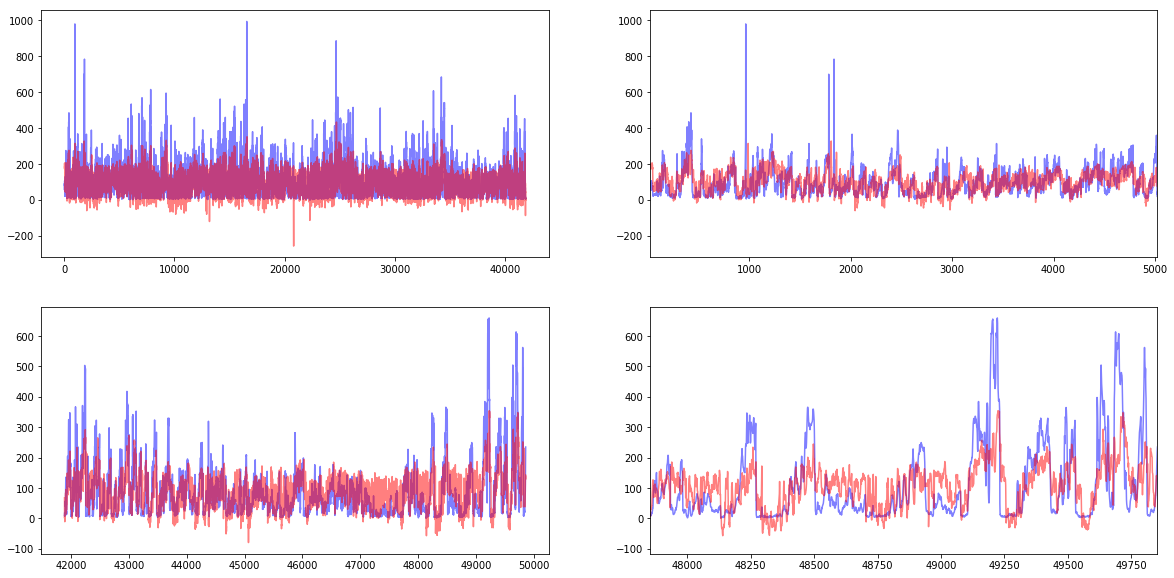

In [29]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

The linear regression model seems to catch some of the periodic trends in both the training and the testing sets, but two major problems are noticed: 
1) the model fails to catch and predict the extremely high PM2.5 values
2) negative PM2.5 values are predicted by the model, whereas in reality, the values should always be non-negative.

### Lasso model

In [30]:
# explore with LASSO model using default parameters

scaler = StandardScaler()
lasso= Lasso()
lasso_1 = Pipeline([('scaler', scaler),('lasso',lasso)])
lasso_1.fit(X_train, y_train)
y_pred_train = lasso_1.predict(X_train)
y_pred_test = lasso_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
feature_rank = pd.DataFrame({'feature':X_train.columns, 'coefficient':lasso_1.named_steps.lasso.coef_})
print(feature_rank.sort_values('coefficient',ascending=False))

0.38892939129908477 0.36963820508636114
4984.314398305273 5217.98261032873
          feature  coefficient
12        pm_1day    26.512010
6            humi    25.677579
3            hour     7.268118
15        cbwd_SE     3.804579
2             day     3.540497
4          season     2.706972
5            dewp    -0.000000
0            year    -0.328454
9   precipitation    -0.715776
1           month    -2.662585
13        cbwd_NE    -5.805120
10          iprec    -6.421212
14        cbwd_NW   -10.416269
7            pres   -11.258708
11             ws   -14.858854
8            temp   -19.676172


In [31]:
# adding PCA as a preprocessing step to decorrelate features

lasso_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('lasso', Lasso())])
lasso_2.fit(X_train, y_train)
y_pred_train = lasso_2.predict(X_train)
y_pred_test = lasso_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(lasso_2.named_steps.lasso.coef_, lasso_2.named_steps.lasso.intercept_)

0.3930249072089348 0.3820799635470391
4950.908538773998 5114.992740362669
[ 34.50370136 -27.61912634  15.52543455  -3.56164623  -8.9516144
   8.96031364 -11.5118155   -2.2258215  -15.60061559   2.35815056
   2.74776505   1.93398135  -0.34450491  10.88176969  -1.56912638
   3.90173448] 97.11600944237445


In [32]:
# grid search of parameter alpha to improve lasso model

parameters = {'lasso__alpha': np.arange(0.1,1,0.1)}
lasso_cv = GridSearchCV(lasso_2, parameters, scoring='r2',cv=3)
lasso_cv.fit(X_train, y_train)
print(lasso_cv.best_params_)
print(lasso_cv.best_score_)

{'lasso__alpha': 0.7000000000000001}
0.37259415785591693


In [33]:
# update model with best parameters

lasso_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('lasso', Lasso(alpha=0.7))])
lasso_3.fit(X_train, y_train)
y_pred_train = lasso_3.predict(X_train)
y_pred_test = lasso_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(lasso_3.named_steps.lasso.coef_, lasso_3.named_steps.lasso.intercept_)

# add scores to the score table
score_table.loc['Lasso',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.39402531283517195 0.3843607529948865
4942.748538773998 5096.112916469917
[ 34.80370136 -27.91912634  15.82543455  -3.86164623  -9.2516144
   9.26031364 -11.8118155   -2.5258215  -15.90061559   2.65815056
   3.04776505   2.23398135  -0.64450491  11.18176969  -1.86912638
   4.20173448] 97.11600944237445


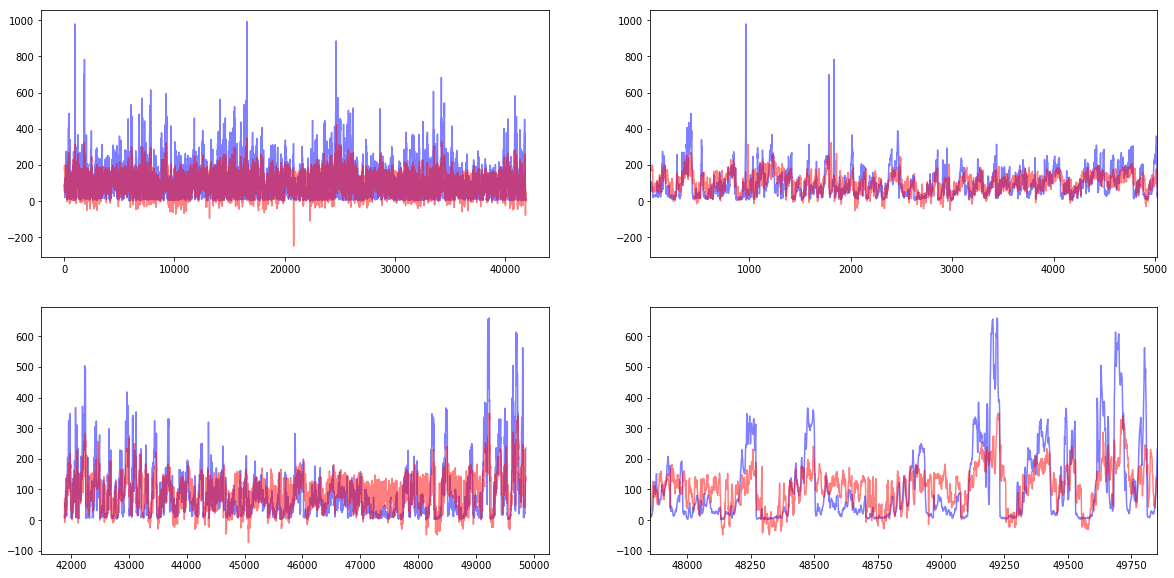

In [34]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### Ridge model

In [35]:
# explore with Ridge model using default parameters

ridge_1 = Pipeline([('scaler', StandardScaler()),('ridge',Ridge())])
ridge_1.fit(X_train, y_train)
y_pred_train = ridge_1.predict(X_train)
y_pred_test = ridge_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
feature_rank = pd.DataFrame({'feature':X_train.columns, 'coefficient':ridge_1.named_steps.ridge.coef_})
print(feature_rank.sort_values('coefficient',ascending=False))

0.3949864740684209 0.3882367620830096
4934.908643178037 5064.028249882416
          feature  coefficient
6            humi    44.626982
12        pm_1day    26.835769
3            hour     8.535463
4          season     5.029031
15        cbwd_SE     4.801545
2             day     4.611673
8            temp     1.901319
9   precipitation    -1.400698
0            year    -1.511931
1           month    -3.286947
13        cbwd_NE    -6.913012
10          iprec    -7.509432
14        cbwd_NW   -11.690053
11             ws   -16.065452
7            pres   -17.962106
5            dewp   -35.588081


In [36]:
# adding PCA as a preprocessing step to decorrelate features

ridge_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('ridge', Ridge())])
ridge_2.fit(X_train, y_train)
y_pred_train = ridge_2.predict(X_train)
y_pred_test = ridge_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(ridge_2.named_steps.ridge.coef_, ridge_2.named_steps.ridge.intercept_)

0.3949864866429048 0.3882431384009316
4934.908540611852 5063.975468263506
[ 35.50285339 -28.6184428   16.52503986  -4.56153728  -9.95137672
   9.96007575 -12.51151666  -3.22574445 -16.6002191    3.35807036
   3.74767554   2.93391128  -1.34447279  11.88148591  -2.56906502
   4.9016174 ] 97.11600944237445


In [46]:
# grid search of parameter alpha to improve Ridge model

parameters = {'ridge__alpha': np.arange(500,1500,50)}
ridge_cv = GridSearchCV(ridge_2, parameters, scoring='r2',cv=3)
ridge_cv.fit(X_train, y_train)
print(ridge_cv.best_params_)
print(ridge_cv.best_score_)

{'ridge__alpha': 900}
0.37136420040878343


In [47]:
# update model with best parameters

ridge_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('ridge', Ridge(alpha=900))])
ridge_3.fit(X_train, y_train)
y_pred_train = ridge_3.predict(X_train)
y_pred_test = ridge_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(ridge_3.named_steps.ridge.coef_, ridge_3.named_steps.ridge.intercept_)

# add scores to the score table
score_table.loc['Ridge',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.39481157093398456 0.38741134125416676
4936.335274076115 5070.8608840392735
[ 34.7565696  -28.016872    16.17767709  -4.46565199  -9.74219491
   9.75071108 -12.24851972  -3.15793805 -16.25127604   3.28748241
   3.66889794   2.87223932  -1.31621145  11.63173245  -2.51506228
   4.7985835 ] 97.11600944237445


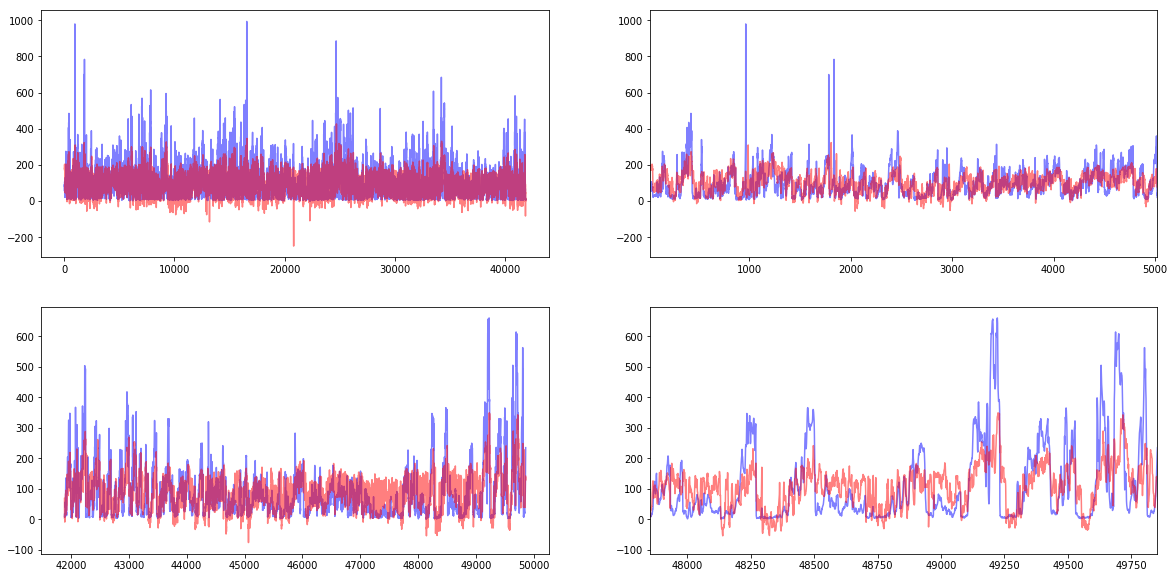

In [48]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### RandomForestRegressor model

In [49]:
# explore with RandomForestRegressor model using default parameters

rfr_1 = Pipeline([('scaler', StandardScaler()),('rfr',RandomForestRegressor())])
rfr_1.fit(X_train, y_train)
y_pred_train = rfr_1.predict(X_train)
y_pred_test = rfr_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(rfr_1.named_steps.rfr.n_features_)
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': rfr_1.named_steps.rfr.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

0.9608757930676245 0.5013451917766953
319.1240834670207 4127.744001716486
16
          feature  importance
6            humi    0.223756
12        pm_1day    0.194384
2             day    0.087160
7            pres    0.075711
5            dewp    0.068693
8            temp    0.060840
11             ws    0.056121
1           month    0.054317
3            hour    0.052163
0            year    0.036259
4          season    0.032793
14        cbwd_NW    0.031156
13        cbwd_NE    0.011188
15        cbwd_SE    0.007597
10          iprec    0.005748
9   precipitation    0.002115


In [50]:
# adding PCA as a preprocessing step to decorrelate features

rfr_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('rfr',RandomForestRegressor(n_jobs=2))])
rfr_2.fit(X_train, y_train)
y_pred_train = rfr_2.predict(X_train)
y_pred_test = rfr_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(rfr_2.named_steps.rfr.n_features_)

0.9453370879123291 0.4912086246942089
445.86850667076686 4211.652054507173
16


In [51]:
# grid search of parameter n_estimators and max_features to improve RandomForestRegressor model

parameters = {'rfr__n_estimators': np.arange(10,200,50), 'rfr__max_features':['auto','sqrt','log2']}
rfr_cv = GridSearchCV(rfr_2, parameters, scoring='r2',cv=3)
rfr_cv.fit(X_train, y_train)
print(rfr_cv.best_params_)
print(rfr_cv.best_score_)

{'rfr__max_features': 'sqrt', 'rfr__n_estimators': 110}
0.4634724186997158


In [52]:
# update model with best parameters

rfr_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('rfr', RandomForestRegressor(n_estimators=110, max_features='sqrt', n_jobs=2))])
rfr_3.fit(X_train, y_train)
y_pred_train = rfr_3.predict(X_train)
y_pred_test = rfr_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(rfr_3.named_steps.rfr.n_features_)

# add scores to the score table
score_table.loc['RandomForestRegressor',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.9621149296711476 0.5473888974246649
309.01682855005225 3746.60533289993
16


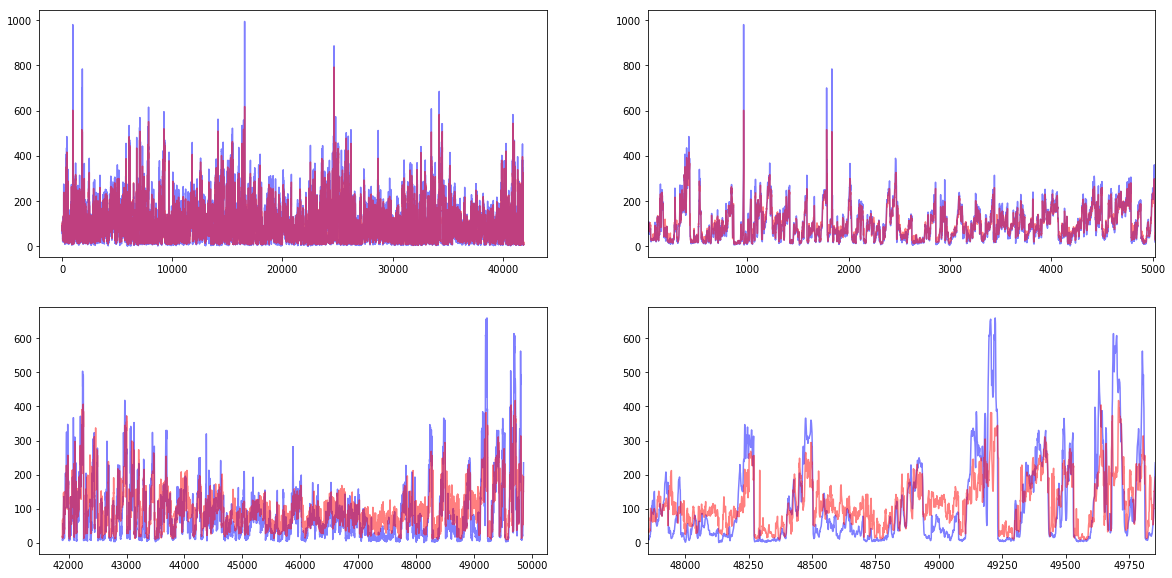

In [53]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### GradientBoostingRegressor model

In [54]:
# explore with GradientBoostingRegressor model using default parameters

gbr_1 = Pipeline([('scaler', StandardScaler()),('gbr',GradientBoostingRegressor())])
gbr_1.fit(X_train, y_train)
y_pred_train = gbr_1.predict(X_train)
y_pred_test = gbr_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(gbr_1.named_steps.gbr.train_score_)
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': gbr_1.named_steps.gbr.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

0.5868886401066704 0.5758237912433075
3369.621889681814 3511.2281532081497
[7641.34518896 7206.42709431 6847.46984725 6535.05001303 6275.17286823
 6047.21688457 5823.05272542 5644.59443978 5480.74646383 5346.29951292
 5221.45004029 5110.50360521 5015.2171995  4933.02612455 4846.01741053
 4780.91035578 4711.77705463 4657.55444301 4609.47291196 4568.5703977
 4517.28135757 4472.76111342 4435.95420297 4395.60729015 4359.85441734
 4316.7075846  4279.48164328 4231.70792142 4211.74855785 4192.80104994
 4175.80644387 4151.47523563 4124.53357838 4090.93995762 4066.54577674
 4045.02567662 4027.38251194 3997.66845185 3973.82965441 3956.66636205
 3917.91937762 3907.85108407 3894.40095299 3875.31772029 3858.91291188
 3844.65532119 3836.51214382 3820.46229377 3803.80562942 3792.51862074
 3766.15082154 3751.84259618 3741.04691481 3725.87687235 3704.15972639
 3697.95080221 3688.00394378 3679.5825234  3673.90728346 3658.30331566
 3649.99253669 3641.64435048 3624.10327552 3616.52583276 3611.9787724
 360

In [55]:
# adding PCA as a preprocessing step to decorrelate features

gbr_2 = Pipeline([('pca',PCA()),('scaler', StandardScaler()),('gbr',GradientBoostingRegressor())])
gbr_2.fit(X_train, y_train)
y_pred_train = gbr_2.predict(X_train)
y_pred_test = gbr_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(gbr_2.named_steps.gbr.train_score_)
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': gbr_2.named_steps.gbr.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

0.5542251785956251 0.5400475145816013
3636.0476663266804 3807.375526017551
[7672.76814854 7270.81845539 6917.54792708 6628.42983475 6361.09422846
 6144.77022707 5947.140814   5785.67107561 5641.1646178  5503.41401978
 5398.61209028 5296.45063404 5203.58654782 5115.15121848 5041.4485735
 4976.98978079 4921.02953131 4863.54253464 4799.51585726 4751.28577397
 4696.82826759 4659.43833372 4621.88662617 4584.64252882 4552.37196965
 4512.61022648 4485.18023507 4450.10611822 4428.9492231  4401.19339905
 4366.4709953  4337.13818917 4308.70294914 4292.30152407 4275.07332626
 4251.21126281 4233.33699715 4211.33309816 4189.80496583 4175.06621336
 4162.41723655 4145.97893677 4125.47755999 4110.34010375 4098.80923612
 4082.56237551 4069.38649677 4055.63614418 4045.25800698 4035.51724442
 4020.50841266 4007.11221012 3995.59946724 3979.98885569 3973.27658096
 3966.1781845  3955.81376467 3942.44470878 3926.75971492 3916.14663656
 3903.42464821 3893.31931239 3885.64080292 3875.15628497 3865.77788273
 38

In [58]:
# grid search of parameter n_estimators, max_features, max_depth, learning_rate to improve GradientBoostingRegressor model

parameters = {'gbr__n_estimators': np.arange(100,600,200), 'gbr__learning_rate': [0.01, 0.05, 0.1],'gbr__max_features':['auto','sqrt'],'gbr__max_depth': np.arange(3,10,3)}
gbr_cv = GridSearchCV(gbr_2, parameters, scoring='r2',cv=3)
gbr_cv.fit(X_train, y_train)
print(gbr_cv.best_params_)
print(gbr_cv.best_score_)

{'gbr__learning_rate': 0.01, 'gbr__max_depth': 6, 'gbr__max_features': 'sqrt', 'gbr__n_estimators': 500}
0.4732409411128933


In [70]:
# update model with best parameters

gbr_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),
                  ('gbr', GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, max_features='sqrt', max_depth=6))])
gbr_3.fit(X_train, y_train)
y_pred_train = gbr_3.predict(X_train)
y_pred_test = gbr_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(gbr_3.named_steps.gbr.train_score_)
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': gbr_3.named_steps.gbr.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

# add scores to the score table
score_table.loc['GradientBoostingRegressor',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.6477714932006764 0.5671875306068626
2873.0192434974597 3582.7170317900286
[8097.26113963 8031.79339644 7973.2206238  7913.71944567 7858.84893969
 7811.61017695 7752.10746816 7702.79419828 7645.51847308 7591.32374779
 7537.08702747 7480.72993507 7435.59463778 7381.0042017  7328.02494189
 7275.91000606 7228.64519255 7182.59923121 7137.54213923 7094.49940777
 7054.29562114 7007.42532406 6967.24104921 6922.52943436 6875.03825529
 6833.47265143 6794.97222353 6751.25326103 6707.21586728 6666.60511057
 6633.62169854 6590.23894119 6552.01546121 6512.76365376 6468.88719536
 6431.47234761 6395.96073333 6355.63130874 6323.48692652 6290.63403361
 6254.11494451 6225.15556448 6192.20043176 6158.65379117 6123.16983011
 6092.7356528  6058.5051473  6030.27559265 5997.70906415 5965.04358451
 5934.55148127 5906.35870823 5875.39975451 5845.59335625 5813.96962144
 5786.01278927 5759.16387376 5728.70406082 5705.77574762 5679.05158149
 5650.96312744 5625.57397303 5599.27855255 5573.2473363  5549.78275338
 

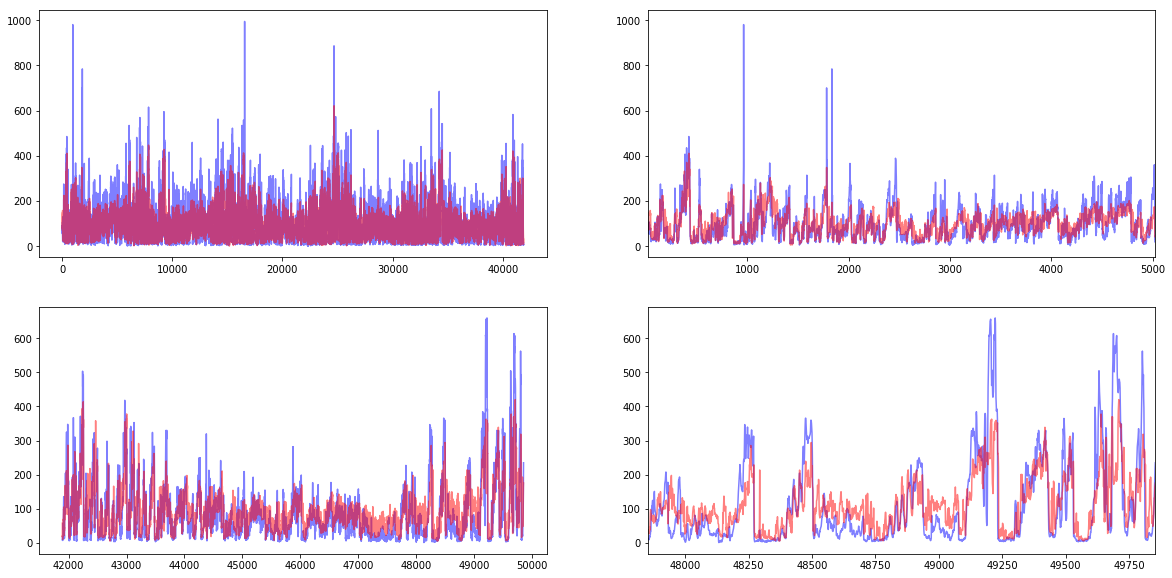

In [61]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### KNeighborsRegressor model

In [62]:
# explore with KNeighborsRegressor model using default parameters

knr_1 = Pipeline([('scaler', StandardScaler()),('knr',KNeighborsRegressor(n_jobs=2))])
knr_1.fit(X_train, y_train)
y_pred_train = knr_1.predict(X_train)
y_pred_test = knr_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)

0.8317037626745115 0.4121297597669211
1372.7404770216976 4866.247788837255


In [63]:
# adding PCA as a preprocessing step to decorrelate features

knr_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('knr',KNeighborsRegressor(n_jobs=2))])
knr_2.fit(X_train, y_train)
y_pred_train = knr_2.predict(X_train)
y_pred_test = knr_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)

0.8198293592850144 0.4229666334831723
1469.5963214082885 4776.542766962517


In [64]:
# grid search of parameters n_neighbors, weights to improve KNeighborsRegressor model

parameters = {'knr__n_neighbors': np.arange(1,100,10),'knr__weights':['distance','uniform']}
knr_cv = GridSearchCV(knr_2, parameters, scoring='r2',cv=3)
knr_cv.fit(X_train, y_train)
print(knr_cv.best_params_)
print(knr_cv.best_score_)

{'knr__n_neighbors': 51, 'knr__weights': 'distance'}
0.4097607333016949


In [65]:
# update model with best parameters

knr_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('knr',KNeighborsRegressor(n_neighbors=51, weights='distance', n_jobs=2))])
knr_3.fit(X_train, y_train)
y_pred_train = knr_3.predict(X_train)
y_pred_test = knr_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)

# add scores to the score table
score_table.loc['KNeighborsRegressor',:] = r2_score_train, r2_score_test, mse_train, mse_test

1.0 0.4794942271840512
2.2210009067252613e-21 4308.621006292798


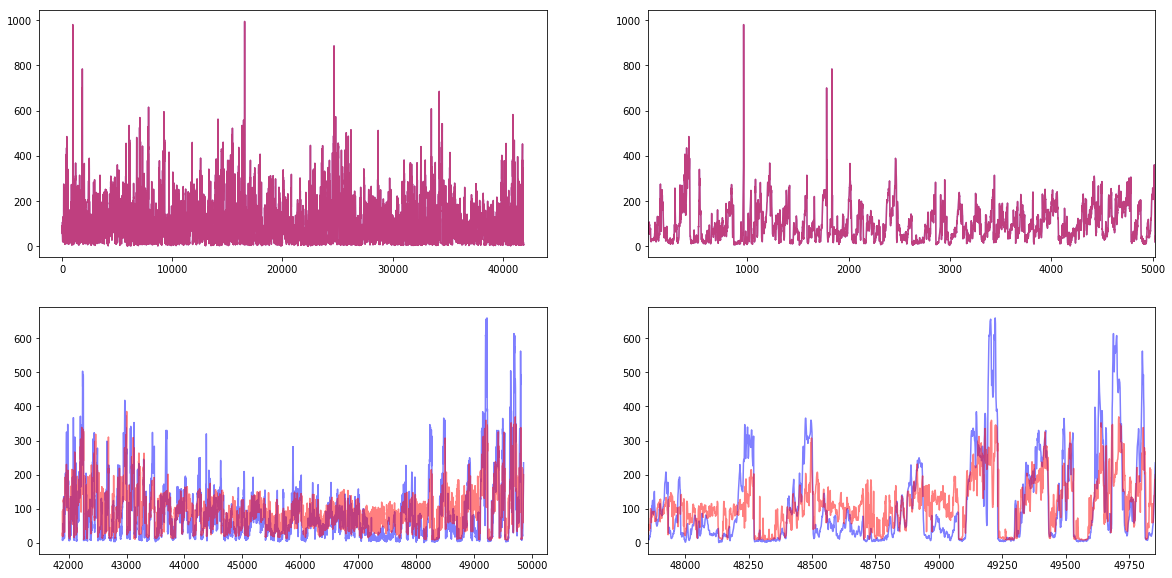

In [66]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

### MLPRegressor model

In [67]:
# explore with MLPRegressor model using default parameters

mlpr_1 = Pipeline([('scaler', StandardScaler()),('mlpr',MLPRegressor())])
mlpr_1.fit(X_train, y_train)
y_pred_train = mlpr_1.predict(X_train)
y_pred_test = mlpr_1.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(mlpr_1.named_steps.mlpr.n_layers_, mlpr_1.named_steps.mlpr.loss_)

0.624567669115426 0.5580000780839054
3062.2856766020222 3658.7685436120278
3 1534.4380738970024


In [68]:
# adding PCA as a preprocessing step to decorrelate features

mlpr_2 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('mlpr',MLPRegressor())])
mlpr_2.fit(X_train, y_train)
y_pred_train = mlpr_2.predict(X_train)
y_pred_test = mlpr_2.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(mlpr_2.named_steps.mlpr.n_layers_, mlpr_2.named_steps.mlpr.loss_)

0.6221589352728796 0.564223793963549
3081.9329752973613 3607.250127531534
3 1545.1301399593287


In [69]:
# grid search of parameters hidden_layer_sizes, activation to improve MLPRegressor model

parameters = {'mlpr__activation': ['identity','logistic','tanh','relu'],'mlpr__hidden_layer_sizes':[(100,),(100,20),(50,100),(50,100,20)]}
mlpr_cv = GridSearchCV(mlpr_2, parameters, scoring='r2',cv=3)
mlpr_cv.fit(X_train, y_train)
print(mlpr_cv.best_params_)
print(mlpr_cv.best_score_)

{'mlpr__activation': 'logistic', 'mlpr__hidden_layer_sizes': (100,)}
0.4914613171052428


In [72]:
# update model with best parameters

mlpr_3 = Pipeline([('pca', PCA()),('scaler', StandardScaler()),('mlpr',MLPRegressor(hidden_layer_sizes=(100,), activation='logistic'))])
mlpr_3.fit(X_train, y_train)
y_pred_train = mlpr_3.predict(X_train)
y_pred_test = mlpr_3.predict(X_test)
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print(r2_score_train, r2_score_test)
print(mse_train, mse_test)
print(mlpr_3.named_steps.mlpr.n_layers_, mlpr_3.named_steps.mlpr.loss_)

# add scores to the score table
score_table.loc['MLPRegressor',:] = r2_score_train, r2_score_test, mse_train, mse_test

0.576295426562712 0.5163451559064863
3456.0274638326027 4003.577923416124
3 1730.494784922284


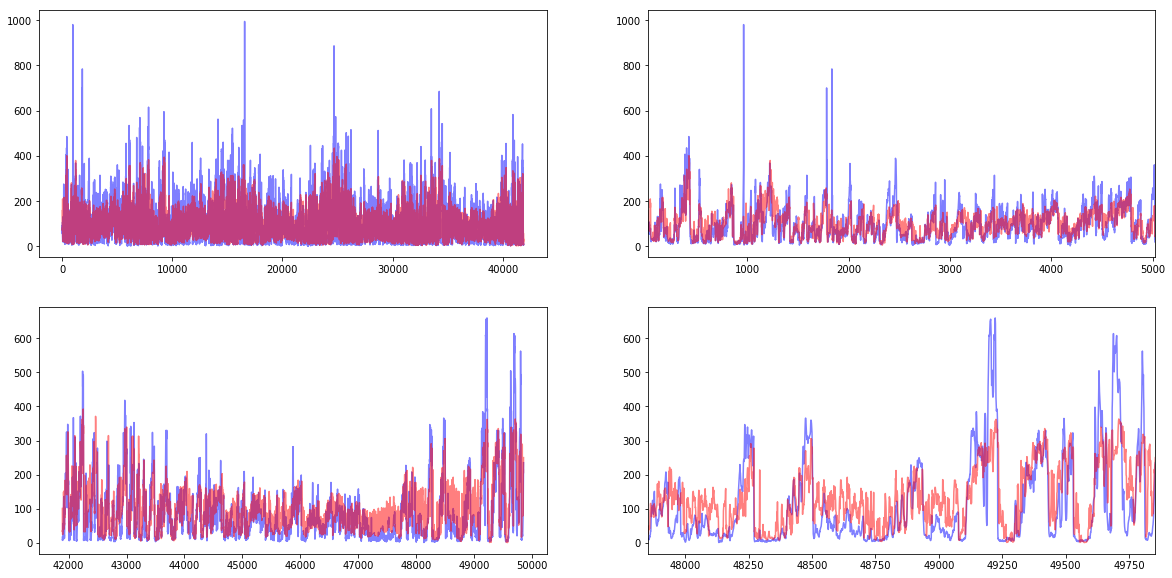

In [73]:
fig = plt.figure(figsize=(20,10))

# plot training set vs prediction
ax1 = fig.add_subplot(221)
ax1.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax1.plot(X_train.index, y_pred_train, color='red',alpha=0.5);

ax2 = fig.add_subplot(222)
ax2.plot(X_train.index, y_train, color='blue',alpha=0.5);
ax2.plot(X_train.index, y_pred_train, color='red',alpha=0.5);
ax2.set_xlim([X_train.index[0],X_train.index[5000]]);

# plot testing set vs prediction
ax3 = fig.add_subplot(223)
ax3.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax3.plot(X_test.index, y_pred_test, color='red',alpha=0.5);

ax4 = fig.add_subplot(224)
ax4.plot(X_test.index, y_test, color='blue',alpha=0.5);
ax4.plot(X_test.index, y_pred_test, color='red',alpha=0.5);
ax4.set_xlim([X_test.index[-2000],X_test.index[-1]]);

In [74]:
# output the summary table of scoring for different algorithms
print(score_table)

                           r2_train   r2_test  mse_train mse_test
LinearRegression           0.394986  0.388244    4934.91  5063.97
Lasso                      0.394025  0.384361    4942.75  5096.11
Ridge                      0.394812  0.387411    4936.34  5070.86
RandomForestRegressor      0.962115  0.547389    309.017  3746.61
GradientBoostingRegressor  0.647771  0.567188    2873.02  3582.72
KNeighborsRegressor               1  0.479494  2.221e-21  4308.62
MLPRegressor               0.576295  0.516345    3456.03  4003.58
